<a href="https://colab.research.google.com/github/briandepasquale/transformer/blob/main/Transformer_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

In [3]:
# ======================================================
# 1. Device Setup
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:

# ======================================================
# 2. Synthetic Data Generator (White Noise with Fixed Lag)
# ======================================================
def generate_batch(batch_size, seq_len, tau, obs_noise=0.05):
    x = torch.randn(batch_size, seq_len)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

In [5]:
# ======================================================
# 2. Synthetic Data Generator (White Noise with Variable τ)
# ======================================================
def generate_batch_var(batch_size, seq_len, tau_min=0, tau_max=10, obs_noise=0.0):
    """
    Each example in the batch has white noise input x, and target y = x shifted by a random τ.
    """
    x_batch = []
    y_batch = []
    tau_list = []

    for _ in range(batch_size):
        x = torch.randn(seq_len)
        tau = torch.randint(tau_min, tau_max + 1, (1,)).item()
        y = torch.roll(x, shifts=tau, dims=0)
        y[:tau] = 0.0
        if obs_noise > 0:
            x = x + obs_noise * torch.randn_like(x)
            y = y + obs_noise * torch.randn_like(y)
        x_batch.append(x)
        y_batch.append(y)
        tau_list.append(tau)

    x_batch = torch.stack(x_batch).unsqueeze(-1)  # (B, T, 1)
    y_batch = torch.stack(y_batch).unsqueeze(-1)
    tau_list = torch.tensor(tau_list)
    return x_batch, y_batch, tau_list

In [6]:
# ======================================================
# 2. Synthetic Data Generator (Sine Wave + Optional Noise)
# ======================================================
def generate_batch_sin(batch_size, seq_len, tau, freq=2.0, obs_noise=0.05):
    t = torch.linspace(0, 2 * math.pi, seq_len)
    x = torch.sin(freq * t).unsqueeze(0).repeat(batch_size, 1)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0
    if obs_noise > 0:
        x = x + obs_noise * torch.randn_like(x)
        y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

In [7]:
def generate_periodic_batch(
    batch_size=64,
    seq_len=1000,
    min_lag=5,
    max_lag=25,
    n_freqs=10,
    noise_std=0.05,
    device='cpu'
):
    """
    Generate a batch of periodic signals with variable lags and additive noise,
    fully in PyTorch.

    Returns:
        x: (B, T, 1)  input sequences
        y: (B, T, 1)  target sequences (lagged)
        lags: (B,)    integer lag for each example
    """

    # Time axis [0, 2π], shape (T,)
    t = torch.linspace(0, 2 * torch.pi, seq_len, device=device)

    # Random frequencies (B, n_freqs)
    freqs = torch.rand(batch_size, n_freqs, device=device) * 10 + 1   # [1,11]

    # Random phases (B, n_freqs)
    phases = torch.rand(batch_size, n_freqs, device=device) * 2 * torch.pi

    # Expand time axis for broadcasting: (B, n_freqs, T)
    t_expanded = t.unsqueeze(0).unsqueeze(0)  # (1,1,T)
    t_expanded = t_expanded.expand(batch_size, n_freqs, seq_len)

    freqs_expanded = freqs.unsqueeze(-1)     # (B, n_freqs, 1)
    phases_expanded = phases.unsqueeze(-1)   # (B, n_freqs, 1)

    # Periodic signal: sum over n_freqs
    signal_components = torch.sin(freqs_expanded * t_expanded + phases_expanded)
    signal = signal_components.sum(dim=1)  # (B, T)

    # Add Gaussian noise
    if noise_std > 0:
        signal += torch.randn_like(signal) * noise_std

    # Sample random lags per example (B,)
    lags = torch.randint(low=min_lag, high=max_lag+1, size=(batch_size,), device=device)

    # Create y by rolling each sequence individually
    y = torch.zeros_like(signal)
    for i, lag in enumerate(lags):
        y[i] = torch.roll(signal[i], shifts=int(lag.item()))
        y[i, :lag] = 0.0  # zero out wrapped section to avoid leakage

    # Add channel dimension
    x = signal.unsqueeze(-1)  # (B, T, 1)
    y = y.unsqueeze(-1)       # (B, T, 1)

    y = torch.tanh(y)
    # ✅ Add noise to the output targets to make the task harder
    y = y + torch.randn_like(y) * noise_std

    return x, y, lags

In [8]:
def generate_periodic_batch(
    batch_size=64,
    seq_len=1000,
    small_lag=20,
    large_lag=220,
    n_freqs=10,
    noise_std=0.05,
    device='cpu'
):
    """
    Generate a batch of periodic signals with *two possible lags* (small or large)
    and additive noise, fully in PyTorch.

    Returns:
        x: (B, T, 1)  input sequences
        y: (B, T, 1)  target sequences (lagged)
        lags: (B,)    integer lag for each example
    """

    # Time axis [0, 2π], shape (T,)
    t = torch.linspace(0, 2 * torch.pi, seq_len, device=device)

    # Random frequencies (B, n_freqs)
    freqs = torch.rand(batch_size, n_freqs, device=device) * 10 + 1   # [1,11]

    # Random phases (B, n_freqs)
    phases = torch.rand(batch_size, n_freqs, device=device) * 2 * torch.pi

    # Expand time axis for broadcasting: (B, n_freqs, T)
    t_expanded = t.unsqueeze(0).unsqueeze(0)  # (1,1,T)
    t_expanded = t_expanded.expand(batch_size, n_freqs, seq_len)

    freqs_expanded = freqs.unsqueeze(-1)     # (B, n_freqs, 1)
    phases_expanded = phases.unsqueeze(-1)   # (B, n_freqs, 1)

    # Periodic signal: sum over n_freqs
    signal_components = torch.sin(freqs_expanded * t_expanded + phases_expanded)
    signal = signal_components.sum(dim=1)  # (B, T)

    # Add Gaussian noise
    if noise_std > 0:
        signal += torch.randn_like(signal) * noise_std

    # 🔥 Sample lags: each example randomly gets either small_lag or large_lag
    choices = torch.tensor([small_lag, large_lag], device=device)
    lags = choices[torch.randint(0, 2, (batch_size,), device=device)]

    # Create y by rolling each sequence individually
    y = torch.zeros_like(signal)
    for i, lag in enumerate(lags):
        y[i] = torch.roll(signal[i], shifts=int(lag.item()))
        y[i, :lag] = 0.0  # zero out wrapped section to avoid leakage

    # Add channel dimension
    x = signal.unsqueeze(-1)  # (B, T, 1)
    y = y.unsqueeze(-1)       # (B, T, 1)

    # Optional nonlinearity
    y = torch.tanh(y)

    # ✅ Add noise to the outputs
    y = y + torch.randn_like(y) * noise_std

    return x, y, lags

In [9]:
# ======================================================
# 3. Positional Encoding
# ======================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, T, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [10]:
# ======================================================
# 4. Transformer Model Setup
# ======================================================
d_model = 64
nhead = 4
num_layers = 2

encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers).to(device)
in_proj = nn.Linear(1, d_model).to(device)
out_proj = nn.Linear(d_model, 1).to(device)
pos_enc = PositionalEncoding(d_model).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(in_proj.parameters()) +
    list(out_proj.parameters()),
    lr=1e-3
)
loss_fn = nn.MSELoss()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class Seq2SeqTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        # Input/output projections
        self.in_proj = nn.Linear(1, d_model)
        self.out_proj = nn.Linear(d_model, 1)

        # Positional encoding
        self.pos_enc = PositionalEncoding(d_model)

        # Encoder and decoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

    def forward(self, src, tgt):
        """
        src: (B, T_src, 1) input sequence
        tgt: (B, T_tgt, 1) target sequence (or zeros if teacher forcing is not used)
        """

        # Project to model dimension
        src = self.in_proj(src)
        tgt = self.in_proj(tgt)

        # Add positional encodings
        src = self.pos_enc(src)
        tgt = self.pos_enc(tgt)

        # Encode/decode
        memory = self.encoder(src)
        out = self.decoder(tgt, memory)

        # Project back to 1D
        return self.out_proj(out)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
model = Seq2SeqTransformer(
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [18]:
save_path = "/content/drive/MyDrive/transformer_model.pt"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/transformer_model.pt


In [20]:
#seq_len = 50
#tau = 5
#batch_size = 64
n_batches = 3000

In [ ]:
loss_history = []
print("Training...")

for step in range(n_batches):
    # Generate training batch
    x, y, _ = generate_periodic_batch()
    x = x.to(device)
    y = y.to(device)

    # Teacher forcing: use zeros as decoder input
    y_in = torch.zeros_like(y)

    # Forward pass through the model
    y_pred = model(x, y_in)  # internally applies in_proj, pos_enc, encoder+decoder

    # Compute loss
    loss = loss_fn(y_pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

In [ ]:
# ======================================================
# 5. Training Loop
# ======================================================
loss_history = []
print("Training...")

for step in range(n_batches):
    #x, y = generate_batch(batch_size, seq_len, tau)
    #x, y = generate_batch_sin(batch_size, seq_len, tau)
    #x, y, _ = generate_batch_var(batch_size, seq_len, tau)
    x, y, _ = generate_periodic_batch()
    x = x.to(device)
    y = y.to(device)

    # Encoder input with positional encoding
    x_emb = pos_enc(in_proj(x))

    # Decoder queries: zeros + positional encoding
    y_zeros = torch.zeros_like(x)
    y_emb = pos_enc(in_proj(y_zeros))

    mem = encoder(x_emb)
    out = decoder(y_emb, mem)
    y_pred = out_proj(out)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

Training...
Step 500/3000, Loss: 0.590540
Step 1000/3000, Loss: 0.586691
Step 1500/3000, Loss: 0.495913
Step 2000/3000, Loss: 0.321982
Step 2500/3000, Loss: 0.313834
Step 3000/3000, Loss: 0.312555


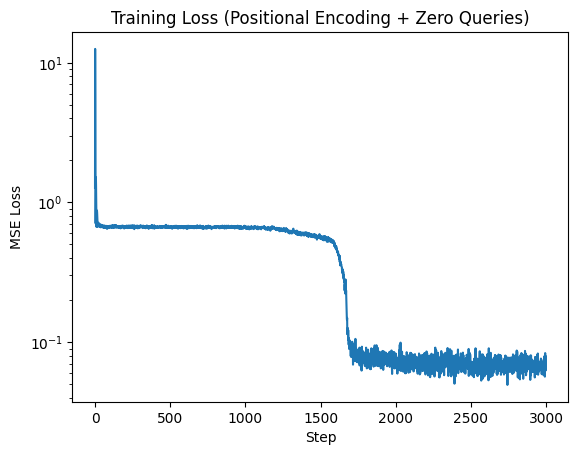

In [ ]:
# Plot training curve
plt.figure()
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.title("Training Loss (Positional Encoding + Zero Queries)")
plt.show()

In [ ]:
# ======================================================
# 6. Cross-Attention Visualization
# ======================================================
encoder.eval()
decoder.eval()

#x_test, y_test = generate_batch(1, seq_len, tau)
#x_test, y_test = generate_batch_sin(1, seq_len, tau)
#x_test, y_test, taus = generate_batch_var(4, seq_len, obs_noise=0.0)
x_test, y_test, taus = generate_periodic_batch()
x_test = x_test.to(device)
y_test = y_test.to(device)

x_emb = pos_enc(in_proj(x_test))
y_emb = pos_enc(in_proj(torch.zeros_like(x_test)))

mem = encoder(x_emb)

# Extract cross-attention from first decoder layer
layer = decoder.layers[0]

# Decoder self-attention to form queries
tgt = y_emb
tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
tgt = layer.norm1(tgt + layer.dropout1(tgt2))

# Cross-attention weights
tgt2, attn = layer.multihead_attn(
    tgt, mem, mem,
    need_weights=True,
    average_attn_weights=True
)

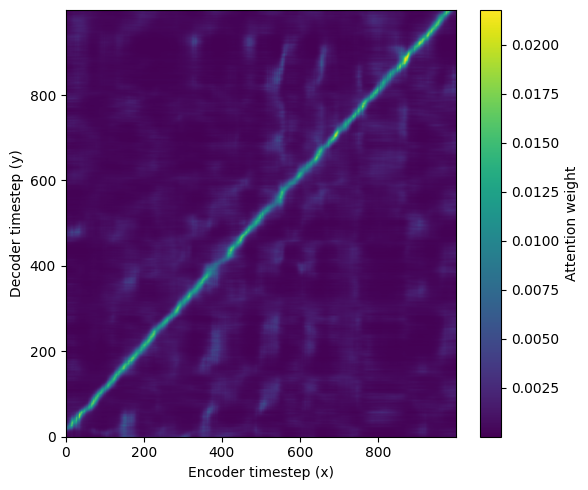

In [ ]:
attn_map = attn[0].detach().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
#plt.title(f'Cross-Attention Map (τ={tau}) — Positional Encoding + Zero Queries')
plt.tight_layout()
plt.show()

In [ ]:
taus

tensor([21, 25,  5, 23, 16, 20,  6, 17, 22,  8, 24,  9, 11,  7, 21, 12, 25, 24,
        24,  6, 21, 10, 15, 24,  9, 12, 24, 23, 19, 24, 12, 24,  6, 24, 19, 10,
        11, 12, 19,  5, 17, 22, 18, 11, 19, 20, 19,  6,  8,  9, 24, 13, 14, 17,
        25, 19, 22, 12, 21, 16, 24,  8, 20,  9])

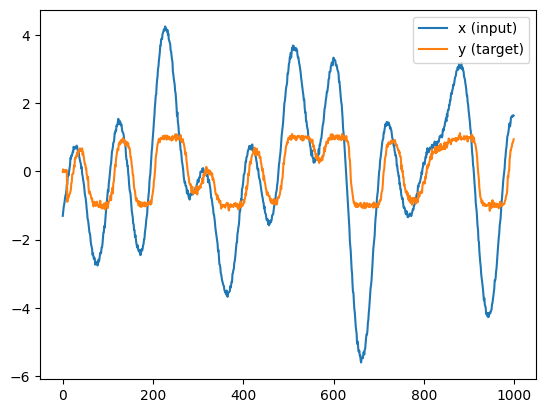

In [ ]:
# Optional: visualize input/output
plt.figure()
plt.plot(x_test[0].cpu().numpy(), label='x (input)')
plt.plot(y_test[0].cpu().numpy(), label='y (target)')
plt.legend()
#plt.title("Example Sine Wave with Lag")
plt.show()

In [ ]:
# attn: (B, T_dec, T_enc)
# lags: (B,) ground truth from generator

# Find ridge per decoder timestep
ridge_x = attn.argmax(dim=2)   # (B, T_dec)

t_dec = attn.size(1)

# 🔥 Corrected delay definition: τ = decoder step - encoder step
delays = torch.arange(t_dec, device=attn.device).unsqueeze(0) - ridge_x  # (B, T_dec)

# Average delay per example
avg_delays = delays.float().mean(dim=1)   # (B,)

/tmp/ipython-input-4293583299.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


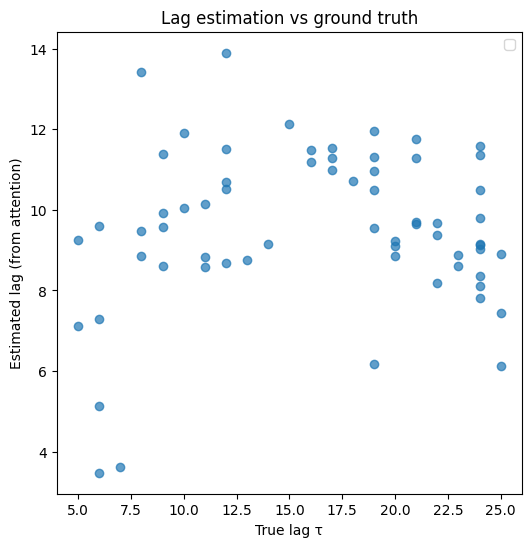

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(taus.cpu(), avg_delays.cpu(), alpha=0.7)
#plt.plot([lags.min(), lags.max()], [lags.min(), lags.max()], 'r--', label="Perfect match")

plt.xlabel("True lag τ")
plt.ylabel("Estimated lag (from attention)")
plt.title("Lag estimation vs ground truth")
plt.legend()
plt.show()